In [1]:
%matplotlib inline

# import libraries
import glob
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Convolution1D, Flatten
from keras.callbacks import EarlyStopping
from keras.layers.noise import GaussianNoise
from sklearn.decomposition import PCA
from keras.preprocessing import image
from scipy import misc
from keras.layers import Convolution2D, MaxPooling2D
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# read in images
images = glob.glob('images/*.jpg')
images = {int(x[7:-4]): misc.imread(x) for x in images}

(271, 654)

In [31]:
# read in data
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

Y_train = X_train['species']
X_train = X_train.drop('species', axis=1)

X_train['image'] = X_train['id'].map(lambda x: images[x])
X_test['image'] = X_test['id'].map(lambda x: images[x])

X_train = X_train.drop('id', axis=1)
#X_test = X_test.drop('id', axis=1)

# one hot encode species
lb = preprocessing.LabelBinarizer()
lb.fit(Y_train)

# Faff around with images
train_images = X_train['image'].map(lambda x: misc.imresize(x,(224,224)))
train_images = train_images.map(lambda x: x.reshape(1, x.shape[0], x.shape[1]))
train_images = np.array(train_images.tolist())
blank_channels = np.zeros((train_images.shape[0], 2, 224, 224))
train_images = np.concatenate((train_images, blank_channels), axis = 1)

test_images = X_test['image'].map(lambda x: misc.imresize(x,(224,224)))
test_images = test_images.map(lambda x: x.reshape(1, x.shape[0], x.shape[1]))
test_images = np.array(test_images.tolist())
blank_channels = np.zeros((test_images.shape[0], 2, 224, 224))
test_images = np.concatenate((test_images, blank_channels), axis = 1)

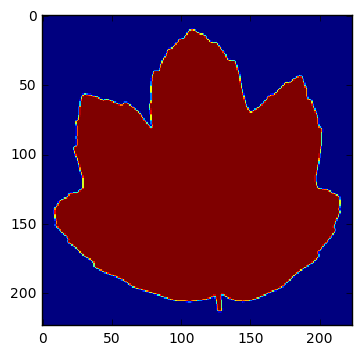

In [25]:
img = train_images[0,0,:,:]
plt.imshow(img, interpolation='nearest')
plt.show()

In [9]:
vgg = VGG16()
for layer in vgg.layers:
    layer.trainable = False
    
x = vgg.get_layer('fc2').output

predictions = Dense(lb.classes_.size, activation='softmax')(x)
model = Model(input=vgg.inputs, output=predictions)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_images,
    lb.transform(Y_train), 
    validation_split=0.2,
    nb_epoch=10
)

Train on 792 samples, validate on 198 samples
Epoch 1/10
792/792 [==============================] - 21s - loss: 4.6406 - acc: 0.2235 - val_loss: 2.3275 - val_acc: 0.5758
Epoch 2/10
792/792 [==============================] - 21s - loss: 1.3789 - acc: 0.7374 - val_loss: 1.9082 - val_acc: 0.6970
Epoch 3/10
792/792 [==============================] - 21s - loss: 0.9637 - acc: 0.8396 - val_loss: 1.6962 - val_acc: 0.7172
Epoch 4/10
792/792 [==============================] - 21s - loss: 0.7808 - acc: 0.9078 - val_loss: 1.6545 - val_acc: 0.7828
Epoch 5/10
792/792 [==============================] - 21s - loss: 0.6920 - acc: 0.9306 - val_loss: 1.4979 - val_acc: 0.8283
Epoch 6/10
792/792 [==============================] - 21s - loss: 0.6515 - acc: 0.9482 - val_loss: 1.4978 - val_acc: 0.8131
Epoch 7/10
792/792 [==============================] - 21s - loss: 0.6173 - acc: 0.9571 - val_loss: 1.4871 - val_acc: 0.8283
Epoch 8/10
792/792 [==============================] - 21s - loss: 0.5984 - acc: 0.9646

In [27]:
from keras.models import load_model
model = load_model('v4-cnn.h5')

In [29]:
predictions = model.predict(test_images)

In [30]:
labels = X_test['id']
headers = lb.classes_.tolist()
headers = ['id']+headers
results = pd.DataFrame(data=predictions)
labels = pd.DataFrame(labels)
results = pd.concat([labels, results], axis=1)
results.columns = headers
results.to_csv('results.csv', index=False)

NameError: name 'test' is not defined